# =============================================================
# MILESTONE 3: Machine Learning Model Development and Optimization
# =============================================================

In [42]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [43]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingRandomSearchCV


In [44]:
url = "https://raw.githubusercontent.com/Reemsoliiman/customer-churn-prediction-analysis/main/data/processed/cleaned_data.csv"
df = pd.read_csv(url)

df.shape

(3333, 86)

# Features (X) and Target (y)

In [45]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Train/test split (80/20) with stratification

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Before SMOTE:", np.bincount(y_train))

Before SMOTE: [2280  386]



# Apply SMOTE only to training set

In [47]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train_resampled))

After SMOTE: [2280 2280]


# =============================================================
# LogisticRegression Model
# =============================================================

Logistic Regression Evaluation:
Accuracy : 0.8605697151424287
Precision: 0.5303030303030303
Recall   : 0.36082474226804123
F1-score : 0.4294478527607362
ROC-AUC  : 0.87724724181588

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       570
           1       0.53      0.36      0.43        97

    accuracy                           0.86       667
   macro avg       0.71      0.65      0.68       667
weighted avg       0.84      0.86      0.85       667


Confusion Matrix:
 [[539  31]
 [ 62  35]]


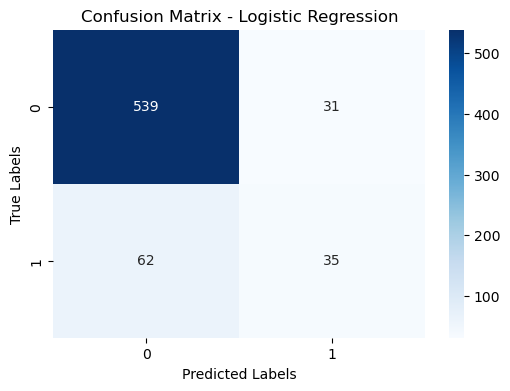

In [48]:
log_reg = LogisticRegression(max_iter=1000, solver="liblinear")
log_reg.fit(X_train_resampled, y_train_resampled)

y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Evaluate Logistic Regression
print("Logistic Regression Evaluation:")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_pred_prob))
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot Confusion Matrix for Logistic Regression
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# =============================================================
# DECISION TREE MODEL
# =============================================================

In [49]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]

print("Decision Tree Evaluation:")
print("Accuracy :", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall   :", recall_score(y_test, y_pred_dt))
print("F1-score :", f1_score(y_test, y_pred_dt))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_dt))

Decision Tree Evaluation:
Accuracy : 0.9370314842578711
Precision: 0.7391304347826086
Recall   : 0.8762886597938144
F1-score : 0.8018867924528302
ROC-AUC  : 0.9118285404232231


# =============================================================
# RANDOM FOREST MODEL
# =============================================================

In [50]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Evaluation:")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1-score :", f1_score(y_test, y_pred_rf))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_rf))

Random Forest Evaluation:
Accuracy : 0.95952023988006
Precision: 0.9166666666666666
Recall   : 0.7938144329896907
F1-score : 0.850828729281768
ROC-AUC  : 0.9365888949177067


# =============================================================
# XGBOOST MODEL
# =============================================================

In [51]:
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Evaluation:")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall   :", recall_score(y_test, y_pred_xgb))
print("F1-score :", f1_score(y_test, y_pred_xgb))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_xgb))

c:\Users\dell\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:46:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Evaluation:
Accuracy : 0.9775112443778111
Precision: 0.9555555555555556
Recall   : 0.8865979381443299
F1-score : 0.9197860962566845
ROC-AUC  : 0.9344908663411106


# =============================================================
# Hyperparameter Tuning
# =============================================================

In [53]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = "roc_auc"

rf_param_dist = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
   "min_samples_split": stats.randint(2, 11),
    "min_samples_leaf": stats.randint(1, 5),
    "max_features": ["sqrt", "log2"]
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=10,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=False
)
rf_search.fit(X_train_resampled, y_train_resampled)
best_rf = rf_search.best_estimator_
print("Random Forest best params:", rf_search.best_params_)
print("Random Forest CV ROC-AUC:", rf_search.best_score_)

y_prob_rf_tuned = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf_tuned = best_rf.predict(X_test)
print("Random Forest (tuned) ROC-AUC:", roc_auc_score(y_test, y_prob_rf_tuned))



xgb_param_dist = {
    
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}


xgb_base = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=1,        
    n_estimators=50  
)

xgb_search = HalvingRandomSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_candidates=12,         
    factor=3,
    resource="n_estimators", 
    max_resources=100,      
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=False,
)

try:
    xgb_search.fit(X_train_resampled, y_train_resampled)
    best_xgb = xgb_search.best_estimator_
    print("XGBoost best params:", xgb_search.best_params_)
    print("XGBoost CV ROC-AUC:", xgb_search.best_score_)
except KeyboardInterrupt:
    print("XGBoost search interrupted. Using best found so far (if any).")
    best_xgb = xgb_search.best_estimator_ if hasattr(xgb_search, "best_estimator_") else xgb_model

y_prob_xgb_tuned = best_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_tuned = best_xgb.predict(X_test)
print("XGBoost (tuned) ROC-AUC:", roc_auc_score(y_test, y_prob_xgb_tuned))



dt_param_grid = {
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

dt_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

dt_search.fit(X_train_resampled, y_train_resampled)
best_dt = dt_search.best_estimator_
print("Decision Tree best params:", dt_search.best_params_)
print("Decision Tree CV ROC-AUC:", dt_search.best_score_)

y_prob_dt_tuned = best_dt.predict_proba(X_test)[:, 1]
y_pred_dt_tuned = best_dt.predict(X_test)
print("Decision Tree (tuned) ROC-AUC:", roc_auc_score(y_test, y_prob_dt_tuned))

log_param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["liblinear"]
}

log_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=2000, random_state=42),
    param_grid=log_param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1
)
log_search.fit(X_train_resampled, y_train_resampled)
best_log = log_search.best_estimator_
print("Logistic Regression best params:", log_search.best_params_)
print("Logistic Regression CV ROC-AUC:", log_search.best_score_)

y_prob_log_tuned = best_log.predict_proba(X_test)[:, 1]
y_pred_log_tuned = best_log.predict(X_test)
print("Logistic Regression (tuned) ROC-AUC:", roc_auc_score(y_test, y_prob_log_tuned))


tuned_comparison = pd.DataFrame([
    {"Model": "Random Forest (tuned)", "ROC-AUC": roc_auc_score(y_test, y_prob_rf_tuned)},
    {"Model": "XGBoost (tuned)", "ROC-AUC": roc_auc_score(y_test, y_prob_xgb_tuned)},
    {"Model": "Decision Tree (tuned)", "ROC-AUC": roc_auc_score(y_test, y_prob_dt_tuned)},
    {"Model": "Logistic Regression (tuned)", "ROC-AUC": roc_auc_score(y_test, y_prob_log_tuned)}
]).sort_values(by="ROC-AUC", ascending=False).round(3)

print("\\nTuned Model Performance (Test ROC-AUC):")
print(tuned_comparison)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Forest best params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}
Random Forest CV ROC-AUC: 0.9938631117266851
Random Forest (tuned) ROC-AUC: 0.9311629589437512
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 5
min_resources_: 1
max_resources_: 100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 1
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 4
n_resources: 3
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 9
Fitting 3 folds for each of 2 candidates, totalling 6 fits


c:\Users\dell\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:51:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost best params: {'subsample': 0.8, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0, 'n_estimators': 9}
XGBoost CV ROC-AUC: 0.9801122460757156
XGBoost (tuned) ROC-AUC: 0.9370681859287393
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Decision Tree best params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Decision Tree CV ROC-AUC: 0.9742347645429364
Decision Tree (tuned) ROC-AUC: 0.9415536263338758
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Logistic Regression best params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression CV ROC-AUC: 0.9738250230840259
Logistic Regression (tuned) ROC-AUC: 0.8892023874118286
\nTuned Model Performance (Test ROC-AUC):
                         Model  ROC-AUC
2        Decision Tree (tuned)    0.942
1              XGBoost (tuned)    0.937
0        Random Forest (tuned)    0.931
3  Logistic Regression (tuned)    0.889


# =============================================================
# MODEL COMPARISON
# =============================================================

In [ ]:
comparison = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_pred_prob)
    },
    {
        "Model": "Decision Tree",
        "Accuracy": accuracy_score(y_test, y_pred_dt),
        "Precision": precision_score(y_test, y_pred_dt),
        "Recall": recall_score(y_test, y_pred_dt),
        "F1-score": f1_score(y_test, y_pred_dt),
        "ROC-AUC": roc_auc_score(y_test, y_prob_dt)
    },
    {
        "Model": "Random Forest",
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Precision": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1-score": f1_score(y_test, y_pred_rf),
        "ROC-AUC": roc_auc_score(y_test, y_prob_rf)
    },
    {
        "Model": "XGBoost",
        "Accuracy": accuracy_score(y_test, y_pred_xgb),
        "Precision": precision_score(y_test, y_pred_xgb),
        "Recall": recall_score(y_test, y_pred_xgb),
        "F1-score": f1_score(y_test, y_pred_xgb),
        "ROC-AUC": roc_auc_score(y_test, y_prob_xgb)
    }
])

print("\nModel Performance Comparison:")
print(comparison.sort_values(by="ROC-AUC", ascending=False).round(3))


Model Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1-score  ROC-AUC
2        Random Forest     0.960      0.917   0.794     0.851    0.937
3              XGBoost     0.978      0.956   0.887     0.920    0.934
1        Decision Tree     0.937      0.739   0.876     0.802    0.912
0  Logistic Regression     0.861      0.530   0.361     0.429    0.877
